<a href="https://colab.research.google.com/github/takakishi/HEC_DS_ML_project/blob/main/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bert-tensorflow
!pip install spacy-transformers
!python -m spacy download fr_core_news_sm
!pip install tensorflow_text

2023-12-11 11:31:56.100738: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 11:31:57.178121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 11:31:57.178270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 11:31:57.365797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 11:31:57.719859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 11:31:57.721767: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Libraries
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
import spacy
import spacy_transformers
import torch
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [3]:
# Import Data
sample_submission = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/sample_submission.csv')
training_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/training_data.csv')
unlabelled_test_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/unlabelled_test_data.csv')

In [4]:
# Training and test set
X = training_data[['sentence']]
y = training_data[['difficulty']]

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder_hot = OneHotEncoder()

encoder_hot.fit(y[['difficulty']])
onehot = encoder_hot.transform(y[['difficulty']]).toarray()
y_onehot = pd.DataFrame(onehot, columns=encoder_hot.get_feature_names_out(['difficulty']))

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder_hot = OneHotEncoder()

encoder_hot.fit(y[['difficulty']])
onehot = encoder_hot.transform(y[['difficulty']]).toarray()
y_onehot = onehot

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_train = X_train['sentence']
X_test = X_test['sentence']

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [9]:
tfhub_handle_preprocess = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3"
tfhub_handle_encoder = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4"

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name='classifier')(net) # kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
  return tf.keras.Model(text_input, net)

In [11]:
classifier_model = build_classifier_model()

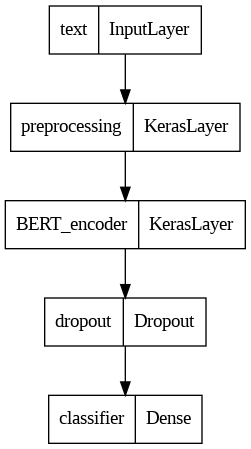

In [12]:
tf.keras.utils.plot_model(classifier_model)

In [13]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

In [15]:
init_lr = 3e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [17]:
y_onehot_tensor = tf.convert_to_tensor(y_onehot)

In [ ]:
classifier_model.fit(X, y_onehot, epochs=1, batch_size=32)

  3/150 [..............................] - ETA: 2:02:01 - loss: 1.9748 - categorical_accuracy: 0.1979

## Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/model.pkl', 'wb') as file:
    pickle.dump(classifier_model, file)

In [ ]:
from google.colab import files
files.download('/content/drive/My Drive/Colab Notebooks/model.pkl')

In [ ]:
# classifier_model.save('/content/drive/MyDrive/model_ANN/bert_multi')

In [ ]:
# y_final = classifier_model.predict(unlabelled_test_data['sentence'])

In [ ]:
# predicted_labels = np.argmax(y_final, axis=1)
# label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
# translated_labels = [label_mapping[idx] for idx in predicted_labels]

In [ ]:
# sample_submission['difficulty'] = translated_labels

In [ ]:
# csv_file_path = '/sample_submission_23.csv'

# Export the DataFrame to CSV
# sample_submission.to_csv(csv_file_path, index=False)

In [ ]:
# from google.colab import files

# Download the CSV file from Colab to your local machine
# files.download("/sample_submission_23.csv")